In [46]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# <center> WINE reviews

In [47]:
# читаем датасет
data = pd.read_csv('data/wine_cleared.csv', index_col='Unnamed: 0')

## <center> 3. Проектирование признаков

In [48]:
# добавляем новый признак со значением округленной цены
data['price_round'] = data['price'].round().astype(int)

### Разбор текста

Создаем признак года происзводства, используя регулярные выражения.

In [49]:
regex = '\d{4}' # регулярное выражение для нахождения чисел
data['year'] = data['title'].str.findall(regex).str.get(0)

### Разбор категорий

Признак производства в США

In [50]:
# если вино произведено в сша то 1, если нет то 0
data['is_usa'] = data['country'].apply(lambda x: 1 if x == 'US' else 0)

Признак производства во Франции и в Италии

In [51]:
data['is_france'] = data['country'].apply(lambda x: 1 if x == 'France' else 0)
data['is_italy'] = data['country'].apply(lambda x: 1 if x == 'Italy' else 0)

Признак года переводим в формат даты

In [52]:
# преобразуем признак year в объект datetime для удобного сравнения дат
data['year'] = pd.to_datetime(data['year'], errors='coerce')

Создаем признак старости вина

In [53]:
# 1 если вино старше 2010 года
data['old_wine'] = data['year'].apply(lambda x: 1 if x.year < 2010 else 0)

Создаем признак долины производства вина из названия

In [54]:
# Nicosia 2013 Vulkà Bianco (Etna)
# создание признака долины производства вина из названия
regex = '\((.*?)\)'
data['locality'] = data['title'].str.findall(regex).str.get(0)

Добавляем признак населения страны из внешнего источника

In [55]:
# читаем новый датафрейм
country_population = pd.read_csv('data/country_population.csv', sep=';')

In [56]:
# объединяем датасет с винами с датасатом со странами
data = data.join(country_population.set_index('country'), on='country')

Добавляем признак площади страны из внешнего источника

In [57]:
# читаем новый датафрейм
country_area = pd.read_csv('data/country_area.csv', sep=';')

# объединяем датасет с винами с датасатом со странами
data = data.join(country_area.set_index('country'), on='country')

Создаем признак количество дней с момента изготовления вина

In [58]:
data['years_diff'] = (pd.to_datetime('01.12.2022') - pd.to_datetime(data['year'])).dt.days

# <center> 5. Кодирование категориальных признаков  
`pip install category_encoders`  
`import category_encoders as ce`

In [59]:
import category_encoders as ce

Кодируем признак года порядковым кодированием

In [60]:
# признак кода переводим в str
data['year'] = data['year'].dt.year.round().astype(str, errors='ignore')

In [61]:
ord_encoder = ce.OrdinalEncoder()
year_col = ord_encoder.fit_transform(data[['year']])
# data = pd.concat([data, year_col], axis=1)
data['year'] = year_col['year']

Кодируем признак обозначающий имя сомелье

In [62]:
encoder = ce.OneHotEncoder(cols=['taster_name']) # указываем столбец для кодирования
names_bin = encoder.fit_transform(data['taster_name'])
data = pd.concat([data, names_bin], axis=1)

Вернёмся к нашему примеру с винным датасетом. Признак country содержит много уникальных значений — используем двоичную кодировку признака.

In [63]:
encoder = ce.BinaryEncoder(cols=['country'])
country_bin = encoder.fit_transform(data['country'])

data = pd.concat([data, country_bin], axis=1)

определите подходящий способ кодирования признака `taster_twitter_handle` из датасета винных обзоров и закодируйте его.

In [64]:
bin_ecnoder = ce.BinaryEncoder(cols=['taster_twitter_handle'])
twit_bins = bin_ecnoder.fit_transform(data['taster_twitter_handle'])

data = pd.concat([data, twit_bins], axis=1)

Нормлализуем признак price

<AxesSubplot:title={'center':'Исходное распределение цены'}, xlabel='price', ylabel='Count'>

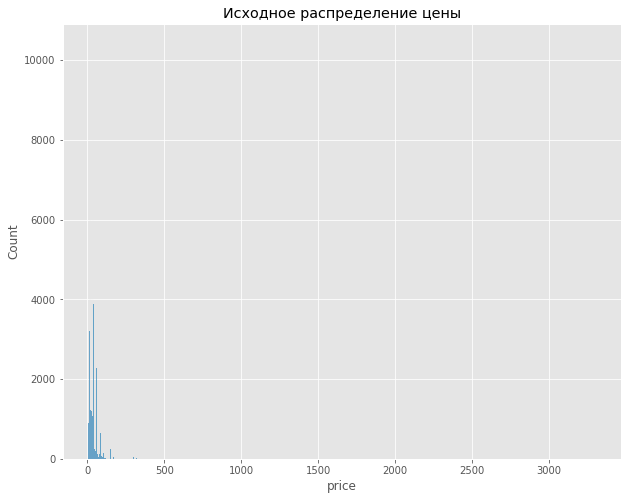

In [65]:
# импортируем модуль из библиотеки
from sklearn import preprocessing

# Для графиков
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходное распределение цены')

sns.histplot(data['price'], ax=ax1, label ='price')

Так как данные распределены не нормально и имеются выбросы, то мы проводим нормализацию с использованием метода Robustscaler

In [66]:
# создаем элемент класса
scaler = preprocessing.RobustScaler()

# копируем датафрейм
scale_df = scaler.fit_transform(data[['price']])

scale_df = pd.DataFrame(scale_df, columns=['price_norm'])
data['price_norm'] = scale_df['price_norm']
# data = pd.concat([data, scale_df], axis=1)
data['price_norm']

0         0.334700
1        -0.590909
2        -0.636364
3        -0.681818
4         1.681818
            ...   
129966    0.000000
129967    0.000000
129968    2.136364
129969    0.090909
129970    0.181818
Name: price_norm, Length: 129972, dtype: float64

In [69]:
data['price_norm'].sum()

43500.63857333408

Стандартизируем исходный признак price

In [30]:
s_scaler = preprocessing.StandardScaler()

stand_df = s_scaler.fit_transform(data[['price_norm']])

stand_df = pd.DataFrame(stand_df, columns=['price_norm'])
# data['price'] = stand_df['price']
stand_df['price_norm'][129968]

-0.1860492115803633

In [31]:
data['price']

0         35.363389
1         15.000000
2         14.000000
3         13.000000
4         65.000000
            ...    
129966    28.000000
129967    75.000000
129968    30.000000
129969    32.000000
129970    21.000000
Name: price, Length: 129972, dtype: float64

In [ ]:
# sns.heatmap(data.corr(), annot=True)
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(40, 40))
# sns.heatmap(
#     data.corr(), 
#     annot=True,
#     ax=axes
# );

In [77]:
corr_data = data.corr()

Ищем мультиколлинеарные признаки

In [82]:
corr_data

,points,price,price_round,year,is_usa,is_france,is_italy,old_wine,area,years_diff,...,country_2,country_3,country_4,country_5,taster_twitter_handle_0,taster_twitter_handle_1,taster_twitter_handle_2,taster_twitter_handle_3,taster_twitter_handle_4,price_norm
points,1.000000,0.402136,0.402064,-0.049948,0.032592,0.059248,0.015926,-0.046069,0.023427,-0.034794,...,-0.036594,-0.019548,0.031306,0.062680,-0.001372,0.050516,-0.140644,0.183248,0.030899,0.398847
price,0.402136,1.000000,0.999997,0.006700,0.025873,0.053139,0.039566,0.055670,0.021446,0.052737,...,-0.070159,0.003017,-0.016842,0.085449,-0.001035,-0.051194,-0.022783,0.058051,-0.056477,0.862474
price_round,0.402064,0.999997,1.000000,0.006689,0.026379,0.052615,0.039314,0.055568,0.021984,0.052654,...,-0.070117,0.002713,-0.016389,0.085427,-0.001031,-0.051023,-0.022453,0.057807,-0.056189,0.862467
year,-0.049948,0.006700,0.006689,1.000000,-0.052228,0.029475,0.017816,0.477721,-0.040911,0.473294,...,0.028799,0.023889,-0.059969,-0.004127,0.006632,-0.019876,0.060176,-0.036893,-0.105809,0.005404
is_usa,0.032592,0.025873,0.026379,-0.052228,1.000000,-0.384584,-0.357477,-0.007442,0.966549,-0.004996,...,-0.302466,-0.542348,0.757849,0.412552,0.005700,0.012343,0.256748,0.000427,-0.042812,0.023688
is_france,0.059248,0.053139,0.052615,0.029475,-0.384584,1.000000,-0.190359,-0.082791,-0.398449,-0.066337,...,-0.161066,0.709109,-0.507468,0.219687,-0.003075,-0.030377,-0.424677,0.446008,-0.300874,0.048262
is_italy,0.015926,0.039566,0.039314,0.017816,-0.357477,-0.190359,1.000000,0.085611,-0.393994,0.081176,...,-0.149713,-0.268448,-0.471699,0.204202,-0.002858,-0.184386,-0.059161,-0.386531,0.142941,0.034502
old_wine,-0.046069,0.055670,0.055568,0.477721,-0.007442,-0.082791,0.085611,1.000000,0.007465,0.502450,...,0.036894,-0.056428,-0.037974,0.027841,0.002861,-0.106602,0.196987,-0.159986,-0.169822,0.048023
area,0.023427,0.021446,0.021984,-0.040911,0.966549,-0.398449,-0.393994,0.007465,1.000000,0.002229,...,-0.221510,-0.534342,0.743601,0.434861,0.007288,0.063930,0.255088,0.011283,-0.042326,0.020170
years_diff,-0.034794,0.052737,0.052654,0.473294,-0.004996,-0.066337,0.081176,0.502450,0.002229,1.000000,...,0.011178,-0.048781,-0.036288,0.025114,0.004775,-0.080616,0.129206,-0.126545,-0.105690,0.047714


In [98]:
for line in corr_data.index:
    for row in corr_data.columns:
        if np.absolute(corr_data.loc[line, row]) > 0.7 and line != row:
            print(f'{line} -- {row} -- {corr_data.loc[line, row]}')

price -- price_round -- 0.9999972843111333
price -- price_norm -- 0.8624737849076136
price_round -- price -- 0.9999972843111333
price_round -- price_norm -- 0.862467489869326
is_usa -- area -- 0.9665486173611894
is_usa -- country_4 -- 0.7578490051469132
is_france -- taster_name_2 -- 0.7356436066762696
is_france -- country_3 -- 0.709109438288848
is_italy -- taster_name_1 -- 0.7147976889772534
area -- is_usa -- 0.9665486173611894
area -- country_4 -- 0.7436008848091432
taster_name_1 -- is_italy -- 0.7147976889772534
taster_name_2 -- is_france -- 0.7356436066762696
taster_name_20 -- taster_twitter_handle_0 -- 1.0
country_3 -- is_france -- 0.709109438288848
country_4 -- is_usa -- 0.7578490051469132
country_4 -- area -- 0.7436008848091432
taster_twitter_handle_0 -- taster_name_20 -- 1.0
price_norm -- price -- 0.8624737849076136
price_norm -- price_round -- 0.862467489869326


Удаляем коррелирующие признаки

In [143]:
data_dropped = data.copy()

Удаляем признаки

In [144]:
data_dropped = data_dropped.drop(columns=['price', 'is_usa', 'is_france', 'is_italy', 'country_4', 'taster_name_20', 'price_round'])
# data_dropped = data.drop(['is_usa', 'is_france', 'is_italy', 'price_round', 'area', 'price'], axis=1)

Проверяем на мультиколлинеарность

In [145]:
corr_data = data_dropped.corr()
for line in corr_data.index:
    for row in corr_data.columns:
        if np.absolute(corr_data.loc[line, row]) > 0.7 and line != row:
            print(f'{line} -- {row} -- {corr_data.loc[line, row]}')